
# How Does Gradient Boosting Regression Work?
### In this notebook, we'll build from scratch a gradient boosted trees regression model that includes a learning rate hyperparameter, and use it to  fit a noisy nonlinear function.<br>
By Joseph Catanzarite 8/21/2020

## 1. The gradient boosting regression algorithm
### In a nutshell: gradient boosting regression successively improves a regression model by adding a correction that is estimated by fitting the error in the previous model to a *weak learner* -- in this case, a shallow decision tree<br><br>

#### A. Basic gradient boosting algorithm
Initialize the *target function* to $f_{1} \equiv y$, and the *estimated correction* to $\hat{C}_{0} \equiv  y_{0} \equiv 0$

For each successive boosting stage $i$, starting at $i=1$,

(1) Compute the *exact correction* $C_{i}$, the difference between the *target function* $f_{i}$ and the *estimated correction* $\hat{C}_{i-1}$ from the previous stage :<br><br>
$$C_{i} = f_{i} - \hat{C}_{i-1}$$ <br><br>

(2) Compute a new *estimated correction* $\hat{C}_{i}$ by fitting the *exact correction* with a shallow decision tree.<br><br>

(3) Update the *model predictions* by adding the *estimated correction*: <br><br>
$$\hat{y}_{i} = \hat{y}_{i-1} + \hat{C}_{i}$$<br><br>

(4) Update the *target function* $f_{i+1}$ for the next stage, which becomes the *exact correction* from this stage:<br><br>
$$f_{i+1} = C_{i}$$<br><br>
#### B. Modified gradient boosting regression algorithm that includes a `learning_rate` hyperparameter
The `learning_rate` parameter $\alpha$ is a positive multiplier which determines how much of the *correction* we want to apply at each boosting stage. For $\alpha = 1$ this becomes the basic boosting algorithm above. The learning rate is a tunable hyperparameter that can provide a regularizing effect by allowing finer corrections at each stage. There is a tradeoff: with learning rates smaller than 1, more *boosting stages* are needed for the model to converge, so `n_estimators` should be increased. 

We modify the basic algorithm by scaling the *estimated corrections* $C_{i-1}$ and $C_{i}$ by the learning rate $\alpha$ in steps (1) and (3): 

Initialize the *target function* to $f_{1} \equiv y$, and the *estimated correction* to $\hat{C}_{0} \equiv  y_{0} \equiv 0$

For each successive boosting stage $i$, starting at $i=1$,

(1) Compute the *exact correction* $C_{i}$, the difference between the *target function* $f_{i}$ and the *estimated correction* $\hat{C}_{i-1}$ from the previous stage, scaled by the learning rate :<br><br>
$${C}_{i} = f_{i} - \alpha \cdot \hat{C}_{i-1}$$ <br><br>

(2) Compute a new *estimated correction* $\hat{C}_{i}$ by fitting the *exact correction* with a shallow decision tree.<br><br>

(3) Update the *model predictions* by adding the *estimated correction* scaled by the learning rate $\alpha$: <br><br>
$$\hat{y}_{i} = \hat{y}_{i-1} + \alpha \cdot \hat{C}_{i}$$<br><br>

(4) Update the *target function* $f_{i+1}$ for the next stage, which becomes the *exact correction* from this stage:<br><br>
$$f_{i+1} = C_{i}$$<br><br>

## 2. Generate noisy observations of a nonlinear function
To the function $y(x) = x\cdot\sin(2x)$, we add a constant offset and unit-variance Gaussian noise.

### Set up environment

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from scipy.interpolate import make_interp_spline
import seaborn as sns

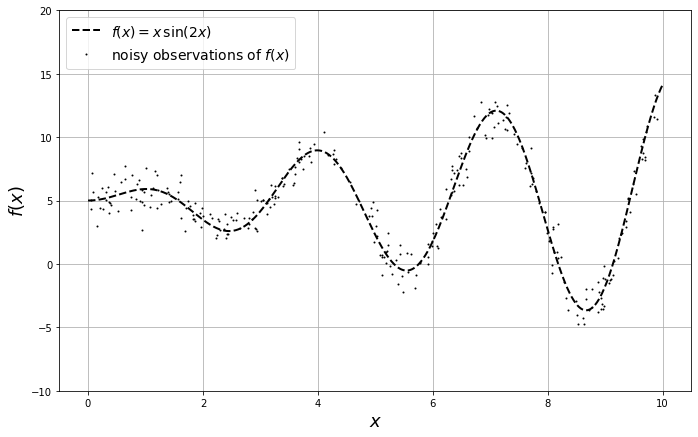

In [2]:
# control parameters
np.random.seed(42)
n_samples = 300
n_grid_samples = 1000
x_min = 0.
x_max = 10.
noise_var = 0.1*x_max
mean = 0.
offset = 5.

# example function to be fitted
def f(x):
    return x * np.sin(2*x)+offset

# generate a random sampling grid, sort the samples
X = np.atleast_2d(np.random.uniform(x_min, x_max, size=n_samples)).T
i_sorted = np.squeeze(np.argsort(X,axis=0))
X = X[i_sorted]

# sample the function perturbed with Gaussian noise on a random grid 
noise = np.random.normal(mean, noise_var, X.flatten().shape)
y = f(X).flatten() +  noise
y_min = min(y)
y_max = max(y)

# create a uniform grid for plotting the function
x_grid = np.atleast_2d(np.linspace(x_min, x_max, n_grid_samples)).T

# plot the function
golden_ratio = (1+np.sqrt(5.))/2.
fig = plt.figure(figsize=(golden_ratio*7,7))
plt.plot(x_grid, f(x_grid), 'k--', linewidth = 2,label=r'$f(x) = x\,\sin(2x)$')
plt.plot(X, y, 'k.', markersize=2, label=r'noisy observations of $f(x)$')
plt.ylim(-x_max, 2*x_max)
plt.grid()
plt.legend(fontsize = 14,loc='upper left')
plt.xlabel('$x$',fontsize = 18)
plt.ylabel('$f(x)$',fontsize = 18);

## 3. Gradient boosting regression from scratch
### We implement the modified gradient boosting regression algorithm that includes a learning rate hyperparameter, and use it to fit our noisy nonlinear function

best RMS prediction error = 0.99
Wall time: 78 ms


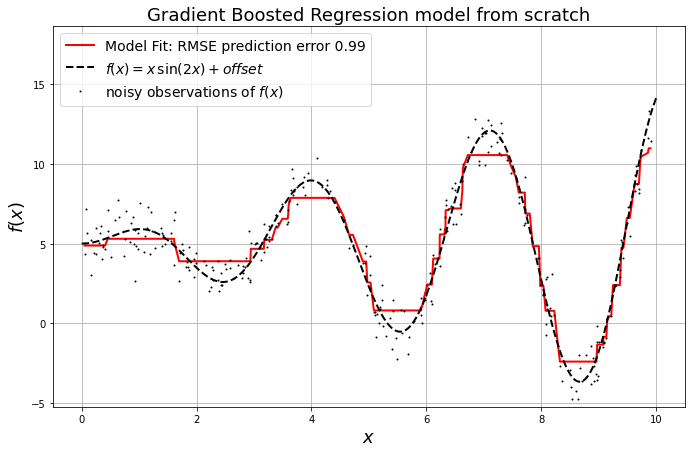

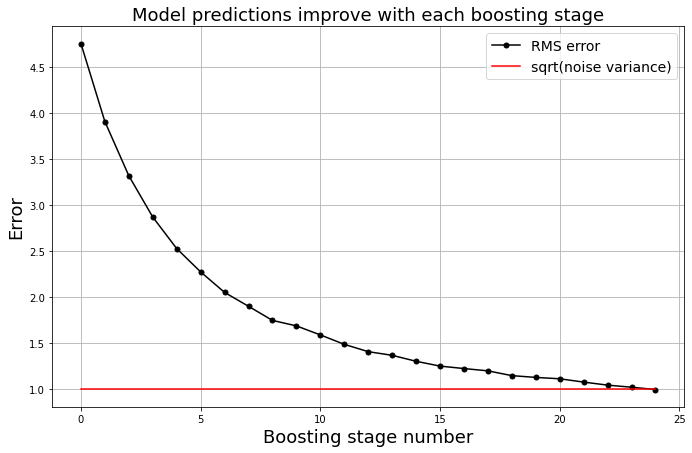

In [3]:
%%time
# initialize
learning_rate = 0.25
n_boosting_stages = 25
y_preds_scratch = 0.
error = np.zeros(n_boosting_stages)
target = y
est_correction = 0.

# plot the function
fig = plt.figure(figsize=(golden_ratio*7,7))

# iterate over a sequence of gradient boosting regression stages
for stage in range(n_boosting_stages):

    # Step 1. Compute the exact correction to the target
    #      note: in the first stage, est_correction is 0. 
    correction = target - learning_rate*est_correction

    # Step 2. Estimate the correction by fitting a decision tree to the exact correction
    regressor = DecisionTreeRegressor(max_depth = 2, min_samples_leaf = 2, random_state = 42)
    est_correction = regressor.fit(X, correction).predict(X)        

    # Step 3. Update the predictions by adding the contribution from the current tree
    y_preds_scratch += learning_rate*est_correction

    # compute the prediction errors at this stage
    error[stage] = np.sqrt(np.mean((y_preds_scratch - y)**2))
    
    # Step 4. Update: the target for the next stage becomes the exact correction from the current stage
    target = correction
    
    # at the last stage, plot the final estimate of the function 
#    if(stage == n_boosting_stages-1):
plt.plot(X, y_preds_scratch, 'r',linewidth = 2,label=f'Model Fit: RMSE prediction error {error[stage]:0.2f}')

# plot the function, the noisy observations of the function, and the estimated function
plt.xlabel('$x$',fontsize = 18)
plt.ylabel('$f(x)$',fontsize = 18)
plt.plot(x_grid, f(x_grid), 'k--', linewidth = 2,label=r'$f(x) = x\,\sin(2x)+offset$')
plt.plot(X, y, 'k.', markersize=2, label=r'noisy observations of $f(x)$')
plt.ylim(1.1*y_min, 1.4*y_max)
plt.legend(fontsize=14,loc='upper left')
plt.title('Gradient Boosted Regression model from scratch', fontsize=18)
plt.grid()

# plot error as a function of boosting stage
fig = plt.figure(figsize=(golden_ratio*7,7))
plt.plot(np.linspace(0, n_boosting_stages-1, n_boosting_stages),error, 'ko-', markersize=5, label='RMS error')
plt.plot([0,n_boosting_stages-1],[noise_var,noise_var],'r-',label=r'sqrt(noise variance)')
plt.xlabel('Boosting stage number',fontsize=18)
plt.ylabel('Error',fontsize=18)
plt.title('Model predictions improve with each boosting stage',fontsize=18)
plt.grid()
plt.legend(fontsize=14,loc='upper right')
print(f'best RMS prediction error = {error[-1]:.2f}')

### The gradient boosted regression model successively improves with each boosting stage

Wall time: 64 ms


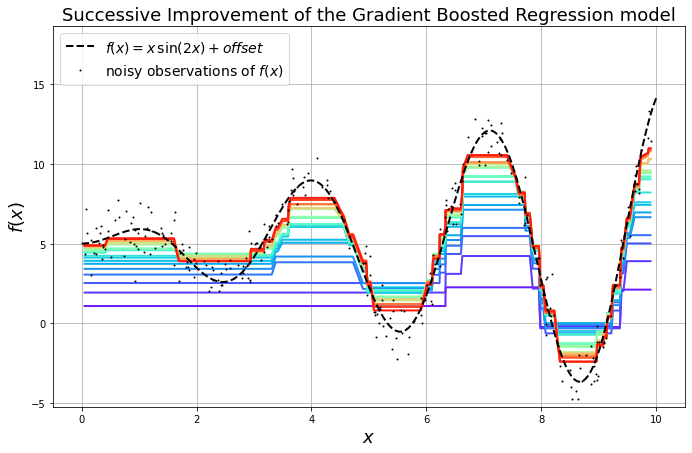

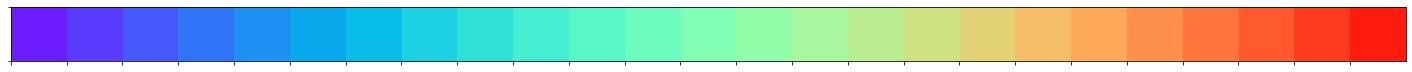

In [4]:
%%time
# initialize
#learning_rate = 0.25
#n_boosting_stages = 25
y_preds_scratch = 0.
error = np.zeros(n_boosting_stages)
sns.set_palette("rainbow",n_boosting_stages)
target = y
est_correction = 0.

# plot the function
fig = plt.figure(figsize=(golden_ratio*7,7))

# iterate over a sequence of gradient boosting regression stages, plotting model at each stage
with sns.color_palette():
 
    for stage in range(n_boosting_stages):

        # Step 1. Compute the correction to the target
        #      note: in the first stage, est_correction is 0. 
        correction = target - learning_rate*est_correction

        # Step 2. ESTIMATE the correction by fitting a decision tree to the correction
        regressor = DecisionTreeRegressor(max_depth = 2, min_samples_leaf = 2, random_state = 42)
        est_correction = regressor.fit(X, correction).predict(X)        

        # Step 3. Update the model predictions by adding the contribution from the current tree
        y_preds_scratch += learning_rate*est_correction

        # compute prediction errors
        error[stage] = np.sqrt(np.mean((y_preds_scratch - y)**2))

        # Step 4. Update: the TARGET for the next stage becomes the correction from the current stage
        target = correction

        # plot successive estimates at each stage
        plt.plot(X, y_preds_scratch,linewidth = 2)        
        
# plot the function and the noisy observations of the function
plt.xlabel('$x$',fontsize = 18)
plt.ylabel('$f(x)$',fontsize = 18)
plt.plot(x_grid, f(x_grid), 'k--', linewidth = 2,label=r'$f(x) = x\,\sin(2x)+offset$')
plt.plot(X, y, 'k.', markersize=2, label=r'noisy observations of $f(x)$')
plt.ylim(1.1*y_min, 1.4*y_max)
plt.legend(fontsize=14,loc='upper left')
plt.title('Successive Improvement of the Gradient Boosted Regression model', fontsize=18)
plt.grid()
sns.palplot(sns.color_palette())

## 4. Comparison with `sklearn` GradientBoostingRegressor
Now we'll compare `sklearn`'s gradient boosting model with the model that we built from scratch

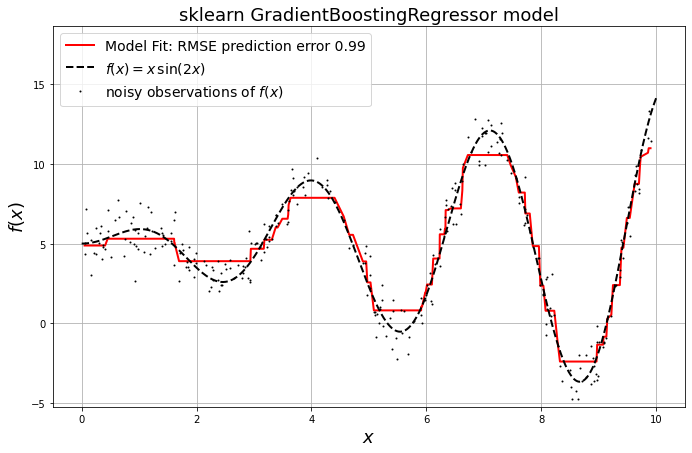

Wall time: 176 ms


In [5]:
%%time
# instantiate a gradient boosting regressor
regressor = GradientBoostingRegressor(loss='ls', random_state = 42,
                                n_estimators = n_boosting_stages, max_depth=2, min_samples_leaf = 2, subsample = 1., max_features = 1.,
                                learning_rate= 0.25)
# Fit the data 
# regressor.set_params(alpha=0.50)
regressor.fit(X, y)

# predict the function
y_preds_sklearn = regressor.predict(X)

# compute the errors
error = np.sqrt(np.mean((y_preds_sklearn - y)**2))

# Plot the function and the prediction
fig = plt.figure(figsize=(golden_ratio*7,7))
plt.plot(X, y_preds_sklearn, 'r',linewidth = 2 ,label=f'Model Fit: RMSE prediction error {error:0.2f}')
plt.plot(x_grid, f(x_grid), 'k--', linewidth = 2,label=r'$f(x) = x\,\sin(2x)$')
plt.plot(X, y, 'k.', markersize=2, label=r'noisy observations of $f(x)$')
plt.xlabel('$x$',fontsize = 18)
plt.ylabel('$f(x)$',fontsize = 18)
plt.ylim(1.1*y_min, 1.4*y_max)
plt.title(u'sklearn GradientBoostingRegressor model', fontsize=18)
plt.legend(loc='upper left',fontsize=14)
plt.grid()
plt.show()

### Result:
#### The predictions of our "from scratch" model are (nearly) identical with those of `sklearn`'s GradientBoostingRegressor! 

In [6]:
print(f'RMS difference between predictions of "from scratch" and sklearn models is {np.sqrt(np.mean((y_preds_scratch-y_preds_sklearn)**2)):.5f}')

RMS difference between predictions of "from scratch" and sklearn models is 0.00340


## 5. Question: why don't we just use a single deep decision tree?
After all, it's much less trouble than gradient boosting!

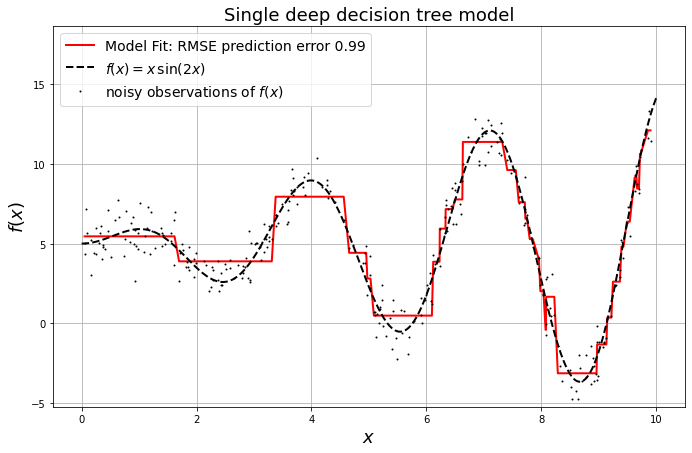

In [7]:
# instantiate a DecisionTreeRegressor model
regressor = DecisionTreeRegressor(random_state = 42, max_depth = 5, min_samples_leaf = 2)
# fit the training data
y_pred = regressor.fit(X, y).predict(x_grid)

# predict on the training data
y_pred_train = regressor.fit(X, y).predict(X)

# compute the error
error = np.sqrt(np.mean((y_pred_train - y)**2))


fig = plt.figure(figsize=(golden_ratio*7,7))
plt.plot(X, y_pred_train, 'r-', linewidth=2, label=f'Model Fit: RMSE prediction error {error:.2f}')
plt.plot(x_grid, f(x_grid), 'k--', linewidth = 2,label=r'$f(x) = x\,\sin(2x)$')
plt.plot(X, y, 'k.', markersize=2, label=r'noisy observations of $f(x)$')
plt.xlabel('$x$',fontsize = 18)
plt.ylabel('$f(x)$',fontsize = 18)
plt.ylim(1.1*y_min, 1.4*y_max)
plt.title('Single deep decision tree model',fontsize=18)
plt.legend(loc='upper left',fontsize=14)
plt.grid()

## Answer: because the gradient boosting model fits the data better!
At a tree depth of 5, the RMS error of the tree model fit is comparable to the noise we added to the data. So increasing the tree depth will overfit to the noise and is not a good idea. It is true that our "from scratch" model has comparable RMS error statistics to the gradient boosting models. However, visual inspection -- comparing with the plots from 1. and 2. above -- shows that the gradient boosting model fits the data better than the deep decision tree.